In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [9]:
import pandas as pd
import urllib
import numpy as np
from tqdm import tqdm
import os
import re
import xarray as xa
from shapely.geometry.point import Point
from pathlib import Path
# import cdsapi

from coralshift.utils import utils, file_ops

In [5]:
def generate_times_from_start_end(
    start_end_dates: list[tuple[pd.Timestamp]]
) -> dict:
    """Generate dictionary containing ecmwf time values from list of start and end dates.

    TODO: update so can span multiple months accurately (will involve several api calls)
    """

    # padding dates of interest + 1 day on either side to deal with later nans
    dates = pd.date_range(start_end_dates[0]-pd.Timedelta(1, 'd'), start_end_dates[1]+pd.Timedelta(1, 'd'))
    years, months, days, hours = set(), set(), set(), []
    # extract years from time
    for date in dates:
        years.add(str(date.year))
        months.add(pad_number_with_zeros(date.month))
        days.add(pad_number_with_zeros(date.day))

    for i in range(24):
        hours.append(f'{i:02d}:00')

    years, months, days = list(years), list(months), list(days)

    time_info = {"year": years, "month": months[0], "day": days, "time": hours}

    return time_info


def fetch_era5_data(
    weather_params: list[str],
    start_end_dates: list[tuple[pd.Timestamp]],
    areas: list[tuple[float]],
    download_dest_dir: str | Path,
    format: str = 'grib'
) -> None:
    """Generate API call, download files, merge xarrays, save as new pkl file.

    Parameters
    ----------
    weather_keys : list[str]
        list of weather parameter short names to be included in the call
    start_end_dates : list[tuple[pd.Timestamp]]
        list of start and end date/times for each event
    area : list[tuple[float]]
        list of max/min lat/lon values in format [north, west, south, east]
    download_dest_dir : str | Path
        path to download destination
    format : str = 'grib'
        format of data file to be downloaded

    Returns
    -------
    None
    """
    # initialise client
    c = cdsapi.Client()

    for i, dates in enumerate(start_end_dates):
        # create new folder for downloads - TODO: FUNCTION
        dir_name = "_".join(utils.dates_from_dt(dates))
        dir_path = guarantee_existence(Path(download_dest_dir) / dir_name)
        # dir_name = '_'.join((
        #     dates[0].strftime("%d-%m-%Y"), dates[1].strftime("%d-%m-%Y")
        #     ))
        # dir_path = guarantee_existence(os.path.join(download_dest_dir, dir_name))

        time_info_dict = generate_times_from_start_end(dates)

        for param in weather_params:
            # generate api call info TODO: FUNCTION
            filename = f"{parameter}.{format}"
            filepath = file_ops.generate_filepath(download_dest_dir, filename, format)
            climate_data.ecmwf_api_call(c, download_dest_dir, param, time_info_dict, areas[i])

            # api_call_dict = generate_api_dict(param, time_info_dict, areas[i], format)
            # file_name = f'{param}.{format}'
            # dest = '/'.join((dir_path, file_name))
            # # make api call
            # try:
            #     c.retrieve(
            #         'reanalysis-era5-land',
            #         api_call_dict,
            #         dest
            #     )
            # # if error in fetching, limit the parameter
            # except TypeError():
            #     print(f'{param} not found in {dates}. Skipping fetching, moving on.')

        # TODO: FUNCTION


        # load in all files in folder

            # filepath = climate_data.generate_spatiotemporal_var_filename(weather_params, dates, area[0], area[1],)
            # save as new file


        # file_paths = file_ops.return_list_filepaths(download_dest_dir, suffix)

        # xa_dict = {}
        # for file_path in tqdm(glob.glob(file_paths)):
        #     # get name of file
        #     file_name = file_path.split('/')[-1]
        #     # read into xarray
        #     xa_dict[file_name] = xr.load_dataset(file_path, engine="cfgrib")

        # # merge TODO: apparently conflicting values of 'step'. Unsure why.
        # out = xr.merge([array for array in xa_dict.values()], compat='override')
        # # save as new file
        # nc_file_name = '.'.join((dir_name, 'nc'))
        # save_file_path = '/'.join((download_dest_dir, nc_file_name))
        # out.to_netcdf(path=save_file_path)
        # print(f'{nc_file_name} saved successfully')


In [18]:
test = (-3,-10,3,5)
min(test)

-10

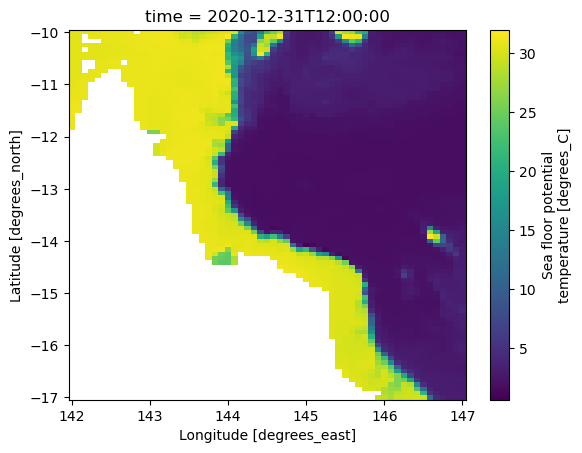

In [17]:
dir = "/Volumes/MRes Drive/global_ocean_reanalysis/daily/bottomTs"
out = file_ops.load_merge_nc_files(dir)
out["bottomT"].isel(time=-1).plot()

In [6]:
out = xa.open_dataarray("/Volumes/MRes Drive/global_ocean_reanalysis/daily/VARS_bottomT_DATES_1993-12-31_2003-12-31_LONS_142_147_LATS_-17_-10_DEPTHS_0_41.nc")

In [7]:
out

<xarray.DataArray 'bottomT' (time: 3652, latitude: 85, longitude: 61)>
[18935620 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -17.0 -16.92 -16.83 ... -10.17 -10.08 -10.0
  * time       (time) datetime64[ns] 1993-12-31T12:00:00 ... 2003-12-30T12:00:00
  * longitude  (longitude) float32 142.0 142.1 142.2 142.2 ... 146.8 146.9 147.0
Attributes:
    long_name:      Sea floor potential temperature
    standard_name:  sea_water_potential_temperature_at_sea_floor
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [   1  681 1440]